# Secrets behind recipes

Team members: Tianyang Dong, Wei Jiang, Huajian Qiu, Jiahua Wu

---
## 0. Import libraries and recipe dataset

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import os

import warnings
warnings.filterwarnings('ignore')
from sklearn.feature_extraction import DictVectorizer
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.decomposition import KernelPCA
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from scipy.spatial.distance import pdist, squareform
import nltk
from nltk.corpus import stopwords
import scipy
import spacy
from nltk.tokenize import RegexpTokenizer
from collections import Counter
import plotly.graph_objects as go

In [3]:
recipe = pd.read_csv('data/RAW_recipes.csv')

In [4]:
recipe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 231637 entries, 0 to 231636
Data columns (total 12 columns):
name              231636 non-null object
id                231637 non-null int64
minutes           231637 non-null int64
contributor_id    231637 non-null int64
submitted         231637 non-null object
tags              231637 non-null object
nutrition         231637 non-null object
n_steps           231637 non-null int64
steps             231637 non-null object
description       226658 non-null object
ingredients       231637 non-null object
n_ingredients     231637 non-null int64
dtypes: int64(5), object(7)
memory usage: 21.2+ MB


In [5]:
# Split the nutrition list
nutritions_list = ["calories(kJ)", "total_fat(g)", "sugar(g)", "sodium(mg)", "protein(g)", "sat_fat(g)", "carbs(g)"]
recipe['nutrition'] = recipe['nutrition'].apply(eval)
recipe[nutritions_list] = pd.DataFrame(recipe.nutrition.values.tolist(), index=recipe.index)
recipe = recipe.drop(['nutrition'], axis=1)

---

# 1. Data Cleaning and Extraction

## 1.1 Map recipe to countries (regions) and continents

First, drop the rows that have nan values on column 'name'. Since 'description' is irrelavent to our analysis, we will not deal with the missing values in column 'description'.

The information about country/region is extracted from the tags, for example, there are tags like 'american', 'southern-united-states', 'scottish'. These tags will be mapped to countries if they describes a part of a country, e.g. 'southern-united-states' to 'America', otherwise they will be mapped to a region, e.g. 'caribbean' to 'Caribbean'. Later the countries will be mapped to continents. 

Due to the variety of country indicators in the tags (for example 'hunan', 'szchuan' indicate China), nlp libraries like spacy cannot ideally identify and capture the country info, so we choose to parse it manually. The resulting mapping is explicitly defined in utils.py for readability of the notebook.

In the end, we get 96940 rows of recipes with country labeled.

In [131]:
from utils import extract_country

In [132]:
recipe.drop(index = recipe[recipe['name'].isna()].index, inplace = True)

In [133]:
recipe.tags = recipe.tags.apply(eval)

In [134]:
recipe_tag = recipe.explode('tags')

In [135]:
recipe_country = extract_country(recipe_tag);

In [136]:
len(recipe_country.country.unique())

66

Recipes of 66 countries are identified.

In [137]:
recipe_count = recipe_country.groupby('country').count()[['name']].rename(columns={'name': 'recipes count'}).sort_values(by='recipes count')

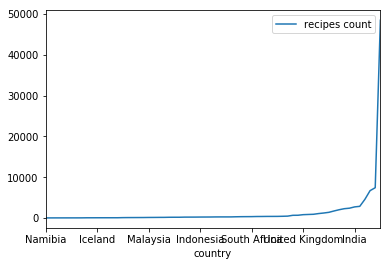

In [138]:
recipe_count.plot()

As we can see, the data is skewed and some countries have too few samples. To reduce the noise in following analysis, we decide to drop the countries with less than 100 recipes in our dataframe.

In [139]:
underrepresented_country_list = recipe_count[recipe_count['recipes count'] < 50].index.tolist()

In [140]:
len(underrepresented_country_list)

15

In [141]:
recipe_country = recipe_country[~recipe_country.country.isin(underrepresented_country_list)]

In [146]:
len(recipe_country)

96294

15 countries are removed. Thus there remains 51 countries in the dataset. And there are 96294 recipes left, which is suffcient for our study.

## 1.2 Ingredients Cleaning

We notice that in some texts of ingredients there are superfluous descriptive words. For example, for flour there are "buckwheat flour", "all-purpose flour" while they should all be categorized as flour. We identify these adjectives as words that are tagged as "JJ"(adjective) by the nltk library. However, we spot some error in tagging (e.g. bean, cake are tagged as adjective) so we first remove some already known ingredients from the adjective set by opearting set difference with the available ingredient list and then we manually check the remaining words to rectify errors.

Then we employ the lemmatization functionality of spacy library to unify the form of words and we furthermore remove the stopping words and punctuations.

Showcase:

In [142]:
recipe_country[recipe_country.id == 27846].ingredients.tolist()

["['margarine', 'all-purpose flour', 'sugar', 'baking powder', 'salt', 'lemon, rind of', 'ground mace', 'egg', 'water', 'purple plums', 'flour', 'ground cinnamon', 'slivered almonds']"]

In [143]:
recipe_country[recipe_country.id == 344542].ingredients.tolist()

["['potatoes', 'zucchini', 'yellow onions', 'garlic cloves', 'self-raising flour', 'eggs', 'of fresh mint', 'fresh basil', 'cracked black pepper', 'sea salt', 'olive oil', 'greek yogurt']",
 "['potatoes', 'zucchini', 'yellow onions', 'garlic cloves', 'self-raising flour', 'eggs', 'of fresh mint', 'fresh basil', 'cracked black pepper', 'sea salt', 'olive oil', 'greek yogurt']"]

In the first example above, we spot some superfluous adjectives like "all-purpose" in "all-purpose flour" and abnormal expression like "lemon, rind of" which should be "lemon rind" and this can be achieved by removing the comma and 'of'. In the second example, "of fresh mint" should be corrected by removing "fresh" and "of". 

In [145]:
len(recipe_country.explode('ingredients').ingredients.unique())

79095

Before cleaning, there are 79095 different ingredients in terms of text. For the comparison of the order of magnitude, recall that in our dataset there are nearly 96000 recipes, such giant number of ingredients implies that many ingredients of the same type are disguised by redundant words such as adjectives and brands' names.

We start by removing adjectives. We initially used spacy library since it is a more recent nlp library but it turned out to be too slow so we turned to nltk.

In [18]:
import nltk

In [19]:
# Collection of words tagged as adjective by nltk
s = set()
for ind, ls in enumerate(recipe_country.ingredients.apply(eval)):
    for word in ls:
        tokens = nltk.word_tokenize(word)
        tagged = nltk.pos_tag(tokens)
        s = s.union(set([ele[0] for ele in tagged if ele[1] == 'JJ']))

In [20]:
# List of misclassified words obtained by manual check
wrongly_classified_list = ['acorn', 'adzuki', 'aji', 'amaranth', 'ancho', 'andouille', 'annatto', 'argan', 'astragalus', 'angelica',
               'bean', 'balsamic', 'bison', 'bisquick', 'blackfish', 'bulgur', 'cachous', 'cake', 'canary', 'cantal', 'cauliflow', 
               'chicory', 'chipotle', 'chocolate', 'chive', 'citric', 'claret', 'cornbread', 'couscous', 'crayfish', 
               'crust', 'curd', 'custard', 'dasheen', 'dough', 'espresso', 'fava', 'fajita', 'feta', 'fish', 'flax', 'garbanzo',
               'geese', 'gelatin', 'gingerbread', 'goldfish', 'gravy', 'lactose', 'lasagna', 'lecithin', 'lemonade', 
               'loin', 'lumpfish', 'macaroni', 'marshmallow', 'mastic', 'menudo', 'mesquite', 'mochiko', 'nacho', 'nixtamal'
               ,'noodle', 'nopal', 'nougat', 'nut', 'parmesan', 'pebble', 'pecan', 'peppercorn', 'phyllo', 'pinto', 'pita',
               'pomfret', 'popcorn', 'poppy', 'cornbread-muffin', 'five-spice', 'garlic-chipotle', 'geese', 'gingerbread', 'gruyere', 
               'guacamole', 'gumbo', 'jalapeno', 'oatmeal', 'pecan', 'peppercorn', 'potatoes', 'quorn', 'robin', 'salad', 'sambal',
               'sandwich', 'sauce', 'savory', 'shellfish', 'shortcrust', 'shortbread', 'soup', 'sourdough', 'soy', 'soybean', 'sushi', 
               'taco', 'udon', 'umeboshi', 'vermicelli', 'waffle', 'weisswurst']

In [21]:
seasoning = ['salt', 'sugar','cheese', 'butter', 'spice','pepper','chili', 'onion','garlic', 'oil',
         'ginger','vineger','clove', 'herb','mayonnaise','vanilla','honey', 'cinnamon', 'curry',
        'mustard', 'olive', 'basil', 'oregano', 'sesame', 'thyme','paprika', 'cajun', 'cardamom',
        'sage', 'rosemary','nutmeg', 'parsley', 'coriander', 'bay', 'cumin', 'tarragon','allspice',
        'cayenne', 'anise', 'celery', 'dill', 'wasabi', 'mace', 'syrup', 'cilantro',
        'salt', 'spice', 'pepper', 'chili', 'onion', 'clove', 'herb', 'olive', 'nutmeg']

In [22]:
# The categoreis (dairy, grain, vegetable, fruit, meat, seafood) are collected from supercook (https://www.supercook.com/#/recipes). 
# 220 various ingredients are identified. 
dairy = ['egg', 'milk', 'cream', 'yogurt', 'frosting'] 
grain = ['rice', 'pasta', 'flour', 'bread', 'tortilla', 'pancake', 'pie', 'pizza']
vegetable = ['tomato', 'potato', 'carrot',
              'broccoli', 'corn', 'spinach', 'mushroom', 'beans', 'salad green', 'cucumber',
              'pickle', 'avocado', 'zucchini', 'cilantro', 'frozen vegetable', 'asparagus',
             'cabbage', 'cauliflower', 'kale', 'mixed vegetable', 'pumpkin', 'squash', 'scallion',
             'shallot', 'eggplant', 'beet', 'horseradish', 'leek', 'caper', 'brussels sprout',
             'artichoke', 'chia', 'radish', 'sauerkraut', 'artichoke', 'arugula', 'capsicum',
             'bok choy', 'parsnip', 'okra', 'yam', 'fennel', 'turnip', 'pea', 'seaweed', 'chard', 'collard',
             'pimiento', 'watercress', 'tomatillo', 'rocket' 'bamboo shoot', 'rutabaga', 'endive',
              'jicama',  'kohlrabi', 'palm', 'butternut', 'daikon', 'radicchio', 'porcini', 'jerusalem artichoke'
             'cress', 'chestnut', 'dulse', 'micro green', 'burdock', 'chayote']
fruit = ['lemon', 'apple', 'banana', 'lime', 'strawberry', 'orange', 'pineapple', 'blueberry', 
             'raisin', 'coconut', 'grape', 'peach', 'cranberry', 'mango', 'pear', 'blackberry', 'cherry',
        'watermelon', 'kiwi', 'grapefruit', 'mandarin', 'craisins', 'cantaloupe', 'plum', 'apricot',
         'clementine', 'prune', 'apple butter', 'pomegranate', 'nectarine', 'fig', 'tangerine', 'papaya',
         'rhubarb', 'sultana', 'plantain', 'currant', 'passion fruit', 'guava', 'persimmon', 'lychee',
         'lingonberry', 'tangelo', 'kumquat', 'boysenberry', 'star fruit', 'quince', 'honeydew', 'crabapple']
meat = ['chicken', 'beef', 'bacon', 'sausage', 'steak', 'ham', 'hot dog', 'pork', 'turkey', 'pepperoni',
       'salami', 'spam', 'venison','bologna', 'bratwurst', 'prosciutto', 'lamb', 'pancetta', 'duck', 'veal',
        'cornish hen', 'deer',  'pastrami', 'rabbit', 'elk', 'marrow bone', 'goose', 'quail', 'oxtail',
 'pheasant', 'moose', 'foie gra', 'boar', 'snail', 'pigeon', 'grouse', 'ostrich', 'soppressata', 'alligator']
seafood =  ['tuna', 'salmon', 'tilapia', 'fish fillets', 'cod', 'anchovy', 'sardine', 'whitefish',
            'halibut', 'trout', 'haddock', 'flounder', 'catfish', 'mahi mahi', 'mackerel', 'sole', 'sea bass',
            'red snapper', 'swordfish', 'pollock', 'herring', 'perch', 'grouper', 'caviar', 'monkfish', 
            'rockfish', 'pike', 'barramundi', 'eel', 'bluefish', 'carp', 'cuttlefish', 'pompano', 'arctic char',
            'john dory', 'marlin', 'amberjack', 'sturgeon', 'shrimp', 'crab', 'prawn', 'scallop', 'clam',
            'lobster', 'mussel', 'oyster', 'squid', 'calamari', 'crawfish', 'octopus', 'cockle', 'conch',
            'sea urchin']
unions = dairy + vegetable + fruit + meat + seafood + grain

In [23]:
adj_to_be_removed = list(s.difference(set(unions + seasoning + wrongly_classified_list)))

In [89]:
# Add some more adjective observed in the ingredient list after the initial attempts of removal.
adj_to_be_removed += ['ground', 'baby', 'bloody', 'jack', 'j', 'john', 'grey', 'gold', 'medium', 'mexico', 
                      'mrs dash', 'mrs', 'non', 'nonpareil', 'z', 'pepsi', 'sodium', 'simply', 'silver', 'sec',
                      'pure', 'pink', 'southwest', 'style', 'tony', 'uncle brand', 'uncle', 'uncle bens', 'use']

In [90]:
# Remove adjectives from the column of ingredients defined above
# nltk fails to identify adjective in form of present, passed participle and possessive case ('s) 
# thus we add those cases here.
def remove_adj(ls):
    for ind, string in enumerate(ls):
        ls[ind] = ' '.join(list(filter(lambda x: x not in adj_to_be_removed 
                                       and not x.endswith('ing') 
                                       and not x.endswith('ed')
                                       and not x.endswith("'s"), string.split())))
    ls = list(set(ls))
    if '' in ls:
        ls.remove('')
    return ls

In [26]:
recipe_country.ingredients = recipe_country.ingredients.apply(eval).apply(remove_adj)

In later operation we find that some ingredients are connected using 'and' and '&' so we split them here.

In [64]:
def split_parallel(ls):
    for string in ls:
        for prop in [' and ', '&']:
            if prop in string:
                ls += string.split(prop)
                ls.remove(string)
    ls = list(set(ls))
    if '' in ls:
        ls.remove('')
    return ls

In [65]:
recipe_country.ingredients = recipe_country.ingredients.apply(split_parallel)

Apply lemmatization to the ingredients to simplify word formats. At the same time, stopping words, punctuation and number are removed.

In [34]:
import spacy
nlp = spacy.load('en')

In [75]:
def word_cleaning(ls):
    for ind, string in enumerate(ls):
        doc = nlp(string)
        ls[ind] = ' '.join([token.lemma_ for token in doc 
                            if token.lemma_ != '-PRON-'
                            and not token.is_stop
                            and token.text.isalpha()])
    ls = list(set(ls))
    if '' in ls:
        ls.remove('')
    return ls

In [76]:
recipe_country.ingredients = recipe_country.ingredients.apply(word_cleaning)

After lemmatization, some adjectives appear so we perform adjective removal again.

In [91]:
recipe_country.ingredients = recipe_country.ingredients.apply(remove_adj)

In [96]:
recipe_country = recipe_country.dropna(subset=['ingredients']).reset_index(drop=True)

In [113]:
len(recipe_country.explode('ingredients').ingredients.unique())

5764

After cleaning, it remains 5764 different ingredients.

In [97]:
recipe_country.to_pickle('recipe_country.pkl')

Link: https://drive.google.com/file/d/1ZBRfYZTGGHZEG4gvP5BRz1IqJl4bUyAL/view?usp=sharing

In [6]:
recipe_country = pd.read_pickle('data/recipe_country.pkl')


## 1.3 Extract seasoning for each recipe

In the column 'ingredients', all the ingredients needed in the recipe are listed. To learn in detail about each country's eating habits, we investigate a particular type of ingredient: seasoning. This study can be justified by the fact that although seasoning is added in small quantities, it plays an important and sometimes a decisive role in the taste of dishes. Therefore its usage can well reflect the eating preference of different regions.

In [5]:
recipe_country_ingre = recipe_country.copy()

In [6]:
seasonings = ['salt', 'sugar', 'butter', 'spice','pepper','chili', 'onion','garlic', 'oil',
         'ginger','vinegar','clove', 'herb','mayonnaise','vanilla','honey', 'cinnamon', 'curry',
        'mustard', 'olive', 'basil', 'oregano', 'sesame', 'thyme','paprika', 'cajun', 'cardamom',
        'rosemary','nutmeg', 'parsley', 'coriander', 'bay', 'cumin', 'tarragon','allspice',
        'cayenne', 'anise', 'celery', 'dill', 'wasabi', 'mace', 'syrup', 'cilantro',
        'salt', 'spice', 'pepper', 'chili', 'onion', 'clove', 'herb', 'olive', 'nutmeg', 'sauce', 'juice',
         'powder', 'harissa', 'sake', 'ketchup', 'mirin', 'miso']

In [7]:
# We identify seasonings as ingredients containing words in the seasoning list instead of exactly the words in the
# list to preserve diversity of seasonings in different countries.
def identify_seasoning(ls):
    res = [string for string in ls if sum(ingredient in string for ingredient in seasonings) > 0]
    if len(res) > 0:
        return res
    return None

In [8]:
recipe_country_ingre['seasoning'] = recipe_country_ingre['ingredients'].apply(identify_seasoning)
recipe_country_ingre.dropna(subset=['seasoning'], inplace=True)
recipe_country_seasoning = recipe_country_ingre.explode('seasoning')

Top 30 frequently used seasoning for each country is computed.

In [195]:
season_country = recipe_country_seasoning.groupby(['country', 'seasoning'])['id'].count().groupby('country').nlargest(30)

In [196]:
season_country = season_country.to_frame().droplevel(0).reset_index()  

In [197]:
# Show frequency of seasonings at the top-30 seasoning list of each country
season_country.groupby('seasoning').count().sort_values(by='id', ascending=False).drop('id', axis=1).rename(columns={'country': 'country count'})

,country count
seasoning,
oil,51
onion,51
pepper,51
sugar,51
garlic clove,51
...,...
celery ribs,1
pepper paste,1
peppercorn,1


In [198]:
season_country.country[season_country['seasoning'] == 'wasabi paste']

805    Japan
Name: country, dtype: object

In [199]:
season_country.country[season_country['seasoning'] == 'tarragon']

472    France
Name: country, dtype: object

In [200]:
season_country.country[season_country['seasoning'] == 'star anise']

859     Malaysia
1525     Vietnam
Name: country, dtype: object

In [201]:
season_country.country[season_country['seasoning'] == 'rice wine vinegar']

265    China
800    Japan
Name: country, dtype: object

In [203]:
season_country.country[season_country['seasoning'] == 'soy sauce'].tolist()

['Australia',
 'Caribbean',
 'China',
 'Hawaii',
 'Indonesia',
 'Japan',
 'Malaysia',
 'New Zealand',
 'Philippines',
 'Polynesia',
 'South Korea',
 'Thailand',
 'Vietnam']

Recall that we identify 51 coutries in total. Therefore, as universal flavorings, salt, salt, pepper, onion, oil, sugar and butter almost appear in recipes of all countries studied. 

In contrast, at the bottom of the sorted list, we may recognize some regional specialties. Used as a pungent condiment for sushi, wasabi is indispensible in most of the japanese recipes. Tarragon is one of the four "fines herbes" of French cooking, and is particularly suitable for chicken, fish, and egg dishes. Soy sauce and rice wine vinegar are mostly used in Asia. Star anise is widely used in Asia and it is also a major ingredient in the making of phở, a Vietnamese noodle soup.

#### Here we show the China's top 20 most frequently used seasonings  as an example. Word cloud is a popular tool for showing word frequencies and visualizing results.

In [60]:
from utils import plt_wordcloud

In [111]:
data = season_country[season_country['country'] == 'China']['seasoning'].values

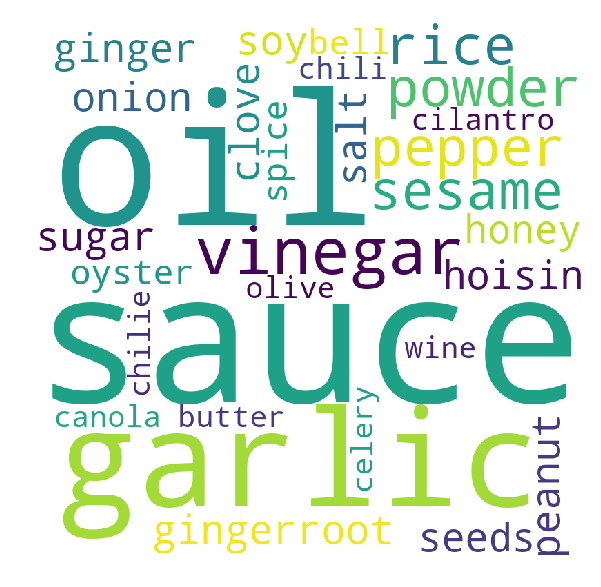

In [112]:
plt_wordcloud(data)

## 1.4 Ingredients Analysis

Unlike seasonings studied above, the main ingredients are major constituents of nutrition in dishes. To get a sense of the nutrition aspect of cuisines in various countries, we analyze main ingredients (ingredients that exclude seasonings) of different recipes.

In [9]:
recipe_country_ingreds = recipe_country.explode('ingredients')

In [10]:
recipe_country_ingreds = recipe_country_ingreds[~recipe_country_ingreds.ingredients.isin(recipe_country_seasoning.seasoning.tolist())]

In [11]:
# Collect the top 15 frequently used ingredients (seasoning removed) in each country
ingredient_country = recipe_country_ingreds.groupby(['country', 'ingredients'])['id'].count().groupby('country').nlargest(20)
ingredient_country = ingredient_country.to_frame().droplevel(0).reset_index()

In [12]:
# Show frequency of each ingredients in the top-10 list
ingredient_country.groupby('ingredients').count().sort_values(by='id', ascending=False).drop('id', axis=1).rename(columns={'country': 'country count'}).head(10)

,country count
ingredients,
water,51
flour,49
eggs,47
milk,40
egg,40
potato,39
tomato,36
cream,32
rice,31


At the top we can see some universal ingredients such as water, garlic clove and eggs.

In [13]:
# Show frequency of each cooking method in the top-5 method list
ingre_country_count = ingredient_country.groupby('ingredients').count().sort_values(by='id', ascending=False).drop('id', axis=1).rename(columns={'country': 'country count'})

In [14]:
# We take out "specialties" which are ingredients that only appear in the top-5 list of a particular country
specialties = ingre_country_count[ingre_country_count['country count'] == 1]

In [15]:
# Add country name to the dataframe
country_df = pd.DataFrame({'country':[ingredient_country.country[ingredient_country.ingredients == ingred].tolist()[0] 
            for ingred in specialties.index], 'ingredients': specialties.index.tolist()})

In [16]:
specialties = specialties.reset_index().merge(country_df)

In [17]:
recipe_ingre_count = recipe_country_ingreds.groupby('ingredients').count().reset_index()

In [18]:
# Add ratio of appearance in dishes of the country
specialties['frequency ratio'] = pd.Series([len(recipe_country_ingreds[(recipe_country_ingreds.country == country) 
                                                                       & (recipe_country_ingreds.ingredients == ingredients)])\
                                            / len(recipe_country[(recipe_country.country == country)]) 
                                             for country, ingredients in zip(specialties.country, specialties.ingredients)])

In [19]:
specialties.sort_values('country')

,ingredients,country count,country,frequency ratio
57,flank steaks,1,Argentina,0.040323
11,skirt steak,1,Argentina,0.056452
24,capsicum,1,Australia,0.043585
59,hazelnuts,1,Austria,0.047059
26,cachaca,1,Brazil,0.072874
22,corn kernel,1,Chile,0.065789
19,broth,1,Chile,0.052632
4,water chestnut,1,China,0.080397
44,marjoram,1,Czechia,0.066176
2,wheat flour,1,Ethiopia,0.056818


In [20]:
specialties[(specialties['country'] == 'Japan') | (specialties['country'] == 'Italy') 
            | (specialties['country'] == 'Netherlands') | (specialties['country'] == 'Switzerland')]

,ingredients,country count,country,frequency ratio
3,sausage,1,Italy,0.057490
6,sushi rice,1,Japan,0.038778
10,shiitake mushroom,1,Japan,0.055229
15,ricotta cheese,1,Italy,0.073819
39,dashi,1,Japan,0.039953
41,emmenthaler cheese,1,Switzerland,0.053333
42,mozzarella cheese,1,Italy,0.172470
53,gruyere cheese,1,Switzerland,0.114667
54,gouda cheese,1,Netherlands,0.053571


At the bottom we see many country specialties and just to name a few: ricotta and mozzarella cheese for Italy, gouda cheese for Netherlands, sushi rice and shiitake mushroom for Japan and gruyere and emmenthaler cheese for Switzerland. 

These particular ingredients appear in more than 10% of the countries' recipes. Specifically, parmesan cheese is used in more than a third of italian recipes and feta cheese is also very popular in greek recipes.

#### Japan's popular ingredients for cooking

In [151]:
data = recipe_country_ingreds[recipe_country_ingreds['country'] == 'Japan']['ingredients'].values

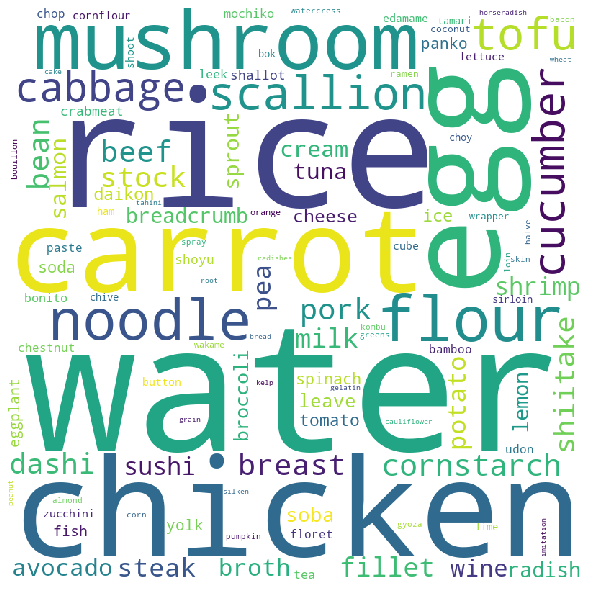

In [152]:
plt_wordcloud(data)

#### Italy's popular ingredients for cooking

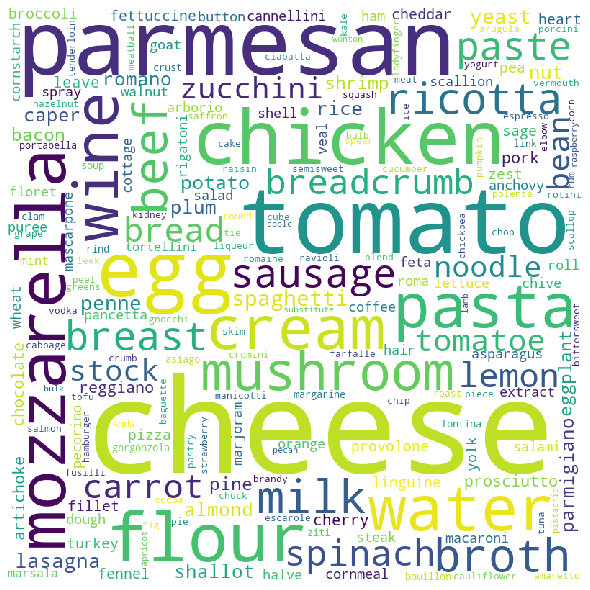

In [153]:
data = recipe_country_ingreds[recipe_country_ingreds['country'] == 'Italy']['ingredients'].values
plt_wordcloud(data)

The wordclouds shown above seem to be in line with common sense. 

In the japanese recipes, we can notice some typical east-asian ingredients such as rice, noodle and tofu and at the same time some japanese specialties emerge: sushi and shiitake mushroom.

Similarly, in italian recipes, different kinds of cheese(parmesan cheese and mozzarella cheese), olive, spaghetti and pasta are largely present. 

Cloudword images on some more countries can be found in our data story.

## 1.5 Extract cooking methods for each recipe

Beside the ingredients, cooking method also varies across country. When 'boiling eggs' or 'frying eggs', the ingredients used are the same, yet the look, the smell and the flavor of the dishes are distinct. In this section we extract cooking methods from column 'steps' from the dataframe.

In [97]:
method_list = ['bake', 'barbecue', 'blanch', 'boil', 'braise', 'brine', 'broil', 'caramelize', 
               'crock pot','deglaze','devein','dice','distill','drain','emulsify',
               'fry','grate','griddle','grill','knead','leaven','marinate','mash','microwave',
               'parboil','pickle','poach','pressure cook','puree','roast','saute','scald',
               'scramble','shred','simmer','slow cook','smoke','sous-vide','steam',
               'stew','tenderize','thicken','toast','whip','whisk']

In [98]:
recipe_cooking = recipe_country.copy()

In [99]:
recipe_cooking['steps'] = recipe_cooking['steps'].apply(eval)

In [155]:
# We apply lemmatization to unify form of words.
recipe_cooking['steps'] = recipe_cooking['steps'].apply(word_cleaning).apply(eval_trim)

In [156]:
recipe_cooking.dropna(subset=['steps'], inplace=True)

In [157]:
# We identify words in the method list that also appear in the text of "steps" and gather them as the cooking 
# methods used in the preperation of the recipe. 
def identify_cooking(row):
    r_list = set([])
    for stc in row:
        s_list = re.findall(r"[\w']+", stc)
        for word in s_list:
            if word in method_list:
                r_list.add(word)
    return list(r_list)

In [158]:
recipe_cooking['method'] = recipe_cooking['steps'].apply(identify_cooking)

In [159]:
recipe_cooking.reset_index(drop = True, inplace = True)

In [160]:
recipe_cooking.drop(index = recipe_cooking[recipe_cooking['method'].apply(len) == 0].index, inplace = True)   

In [161]:
recipe_cooking_e = recipe_cooking.explode('method')

In [169]:
# Take out the top 10 used cooking methods in recipes of each country
method_country = recipe_cooking_e.groupby(['country', 'method'])['id'].count().groupby('country').nlargest(10)
method_country = method_country.to_frame().droplevel(0).reset_index()  

In [170]:
# Show frequency of each cooking method in the top-10 method list
method_country.groupby('method').count().sort_values(by='id', ascending=False).drop('id', axis=1).rename(columns={'country': 'country count'})

,country count
method,
bake,51
boil,51
simmer,51
drain,51
fry,50
saute,46
whisk,40
thicken,32
grill,27


In [171]:
method_country.country[method_country['method'] == 'dice']

346    Palestine
Name: country, dtype: object

In [172]:
method_country.country[method_country['method'] == 'broil']

428    South Korea
Name: country, dtype: object

In [177]:
recipe_cooking.to_pickle('recipe_cooking.pkl')

Link: https://drive.google.com/file/d/1auyrjRxY9DUflrQlULKI3B1k3OZ_D0e_/view?usp=sharing

Basic methods like boil, simmer, drain and bake are largely present in recipes of various countries for food cooking. Broil is popular in korean recipes mainly because of "Korean BBQ".

In [172]:
recipe_cooking = pd.read_pickle('data/recipe_cooking.pkl')

#### Japan's cooking method wordcloud

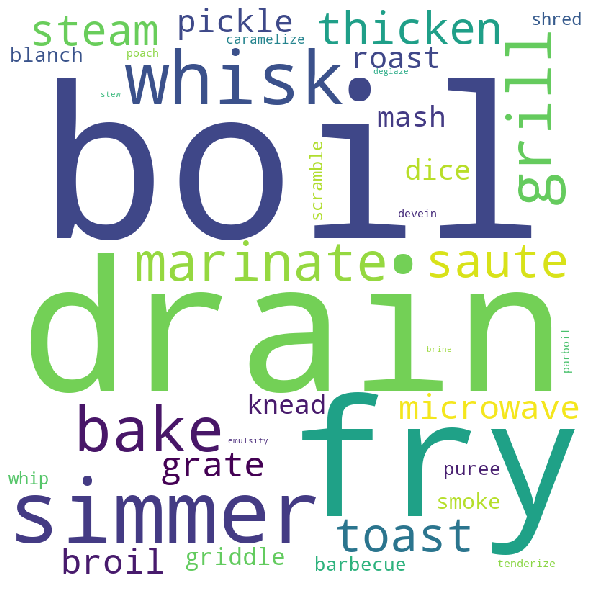

In [167]:
data = recipe_cooking_e[recipe_cooking_e['country'] == 'Japan']['method'].values
plt_wordcloud(data)

#### Italy's cooking method wordcloud

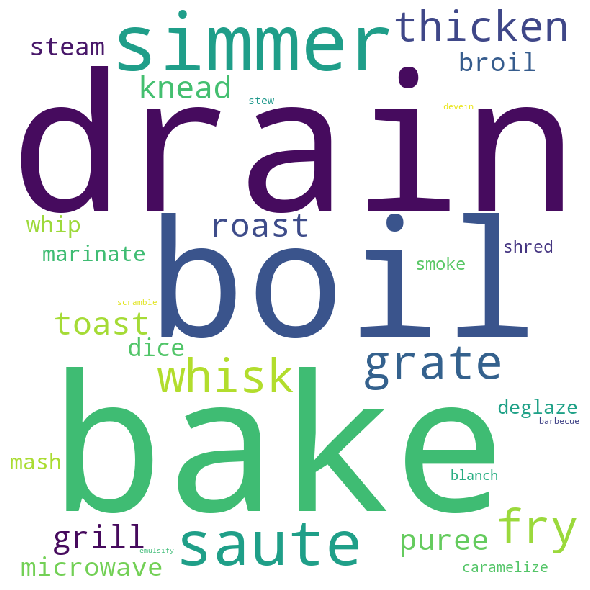

In [168]:
data = recipe_cooking_e[recipe_cooking_e['country'] == 'Italy']['method'].values
plt_wordcloud(data)

Italian recipes and japanese recipes reflect respectively typical western and asian food cooking habits. Both of them are mostly prepared by draining, boiling and simmering, which is the case of most of the countries. However, They still slightly differ from each other: marinate is more present as a food preprocessing step in japanese recipes while baking appears more frequently in italian recipes. Such difference is reasonable since food made by baking (for instance bread and cake) is essential in western diet while marinate plays an important role in east-asian cuisine for refining the taste of ingredients.

## 1.6 Drawing the choropleth map of the nutrition facts

Nutrition in the diet has a direct impact on people's health. We draw here a choropleth map based on the average nutrition facts of the dishes from different countries.

In [7]:
avg_nutrition = recipe_country.groupby("country").mean()

In [ ]:
avg_nutrition = avg_nutrition[nutritions_list].reset_index()

In [162]:
import geopandas
from matplotlib import cm

In [163]:
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))

In [164]:
avg_nutrition = avg_nutrition[~avg_nutrition.country.isin(['Caribbean', 'Hawaii', 'Melanesia', 'Polynesia'])].reset_index(drop=True)

In [165]:
merged = world.set_index('name').join(avg_nutrition.set_index('country'))

In [168]:
merged.to_csv('merged.csv')

In [169]:
merged.to_file("merged.json", driver="GeoJSON")

In [143]:
def plot_nutrition(column):
    # plot as usual, grab the axes 'ax' returned by the plot
    colormap = "OrRd"   # add _r to reverse the colormap
    ax = merged.plot(color="grey", figsize=(12, 9))
    ax2 = merged.dropna().plot(ax=ax, column=column, cmap=colormap, figsize=[12,9])

    # map marginal/face deco
    ax2.set_title("Average " + column + " in recipes from different countries" + \
                  "\n (missing values are plotted in grey)")

    # colorbar will be created by ...
    fig = ax2.get_figure()
    # add colorbar axes to the figure
    # here, need trial-and-error to get [l,b,w,h] right
    # l:left, b:bottom, w:width, h:height; in normalized unit (0-1)
    cbax = fig.add_axes([0.95, 0.3, 0.03, 0.39])   
    cbax.set_title(column)

    sm = plt.cm.ScalarMappable(cmap=colormap, \
                    norm=plt.Normalize(vmin=min(merged[column].dropna()), vmax=max(merged[column].dropna())))
    # at this stage, 
    # 'cbax' is just a blank axes, with un needed labels on x and y axes

    # blank-out the array of the scalar mappable 'sm'
    sm._A = []
    # draw colorbar into 'cbax'
    fig.colorbar(sm, cax=cbax, format="%d")

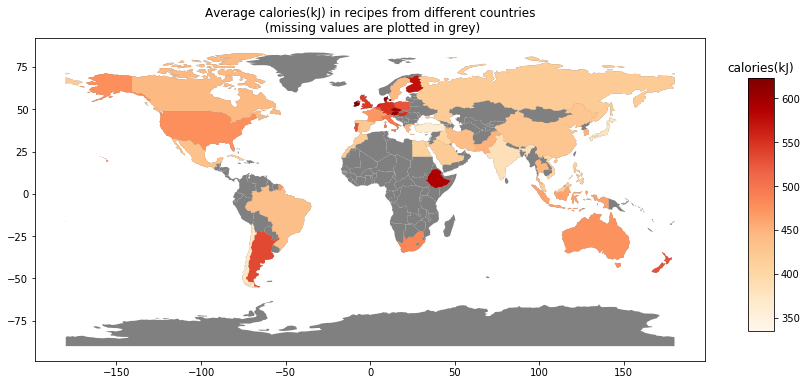

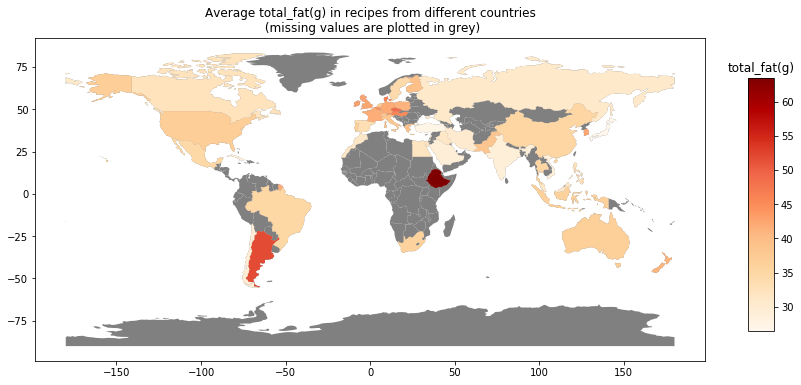

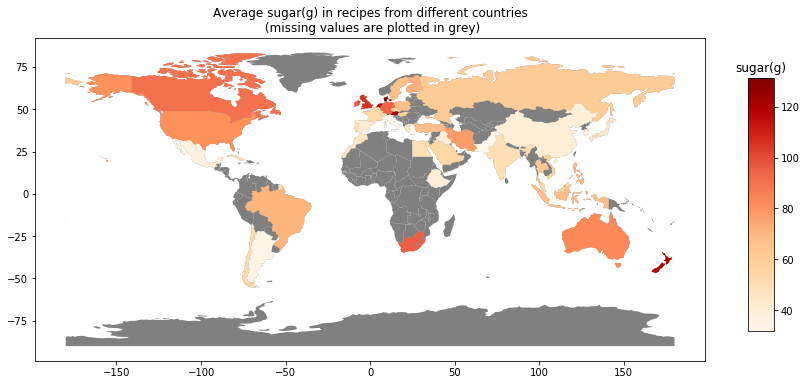

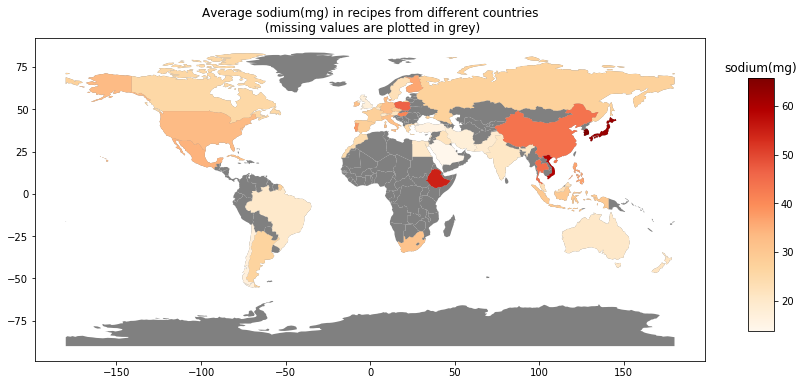

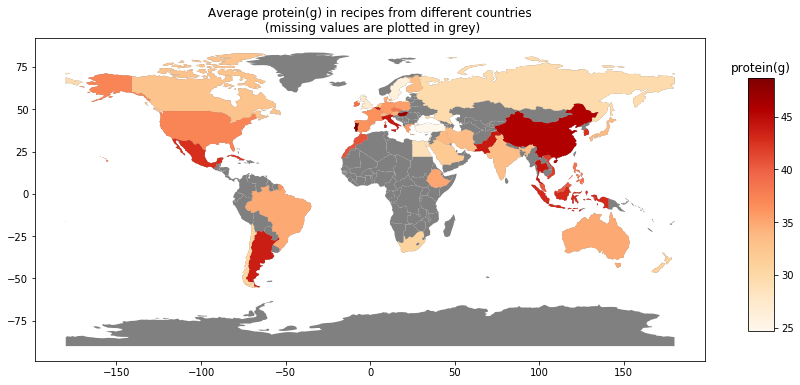

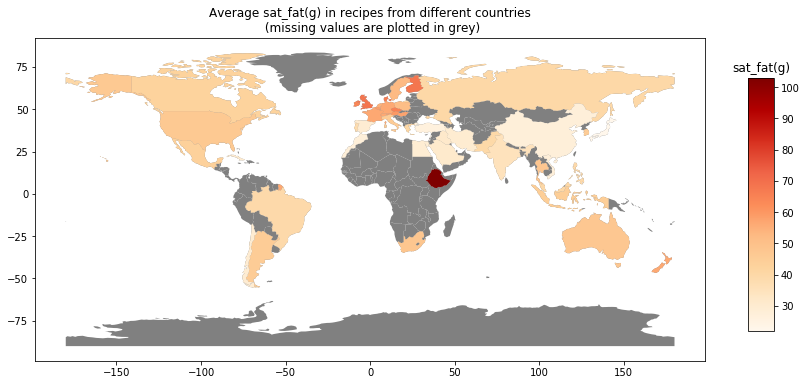

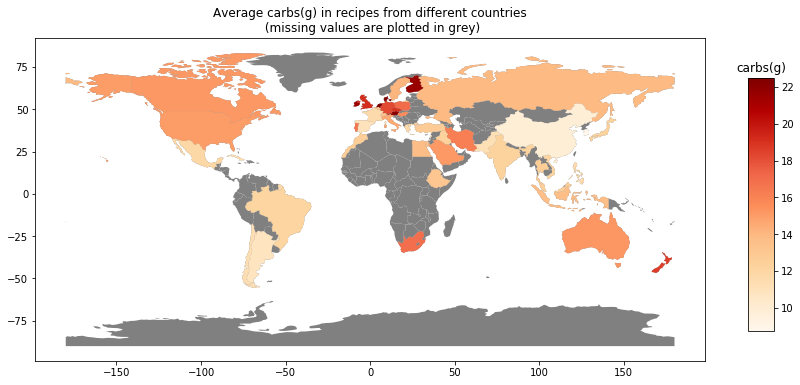

In [145]:
for column in nutritions_list:
    plot_nutrition(column)

Clearly, recipes originated from western countries(european countries, US, Canada and Australia) tend to contain relatively high calories, high fat, high sugar, high carbs and low sodium. On the contrary, recipes of east asian countries tend to contain high sodium and high proteins. These characterizaions have important influence on statistics related to health that we include later.

# 2. Similarity and flow chart representation of correlation
In this section, we want to see how different recipes are related. Since the similariry of recipes based on ingredients is widely studied by previous students. We decide to study the simimilarity between recipes based on preperation steps. The basic idea is to first remove stop words from steps and then use bags of words vectors to represent the step of each. And then we use PCA and t-SNE to reduce the dimension to three dimension. The 3D result is visualized in our Data story, here we only present 2D results.

To show the level of correlation between different factors more clearly, we use flow chart for demonstration where the thicker the connection is, the stronger the correaltion is. The flow chart is created using plotly functionalities thus we can only show the code here and the resulting graphs are available in our data story.

## 2.1 Similarity Visualization through PCA and T-SNE

In [3]:
recipe_country = pd.read_pickle('data/recipe_country.pkl')
nlp = spacy.load('en')
nlp.vocab["minutes"].is_stop = True
nlp.vocab["hours"].is_stop = True
nlp.vocab["seconds"].is_stop = True
nlp.vocab["'s"].is_stop = True
spacy_stopwords = spacy.lang.en.stop_words.STOP_WORDS

In [5]:
#Helper function to convect an array of ingredients to a dictionary
def convert_to_dict(arr):
    d={}
    for a in arr:
        d[a]=1
    return d
# helper function to tokenize and remove number, stop words
def clean(strs):
    tokenizer = RegexpTokenizer(r'(?=\D)\w{2,}')
    rm_punc = tokenizer.tokenize(strs)
    doc = nlp(' '.join(rm_punc))
    tokens = [token.text for token in doc if token.text not in spacy_stopwords]
    return dict(Counter(tokens))

Since the recipes from multiple counties are possible to mixture features, this will make the underlying clustering phenomenon with respect to countries ambiguous. So we decide to only keep the recipes classified to only one country.

In [9]:
df_smaller = recipe_country[['id', 'country', 'continent', 'ingredients', 'steps']]
df_single_coun = df_smaller[df_smaller.id.isin(df_smaller.id.value_counts()[(df_smaller.id.value_counts() == 1)].index)]
df_single_coun.head()

,id,country,continent,ingredients,steps
2,31490,United States of America,North America,"['prepared pizza crust', 'sausage patty', 'egg...","['preheat oven to 425 degrees f', 'press dough..."
5,44061,United States of America,North America,"['tomato juice', 'apple cider vinegar', 'sugar...",['mix all ingredients& boil for 2 1 / 2 hours ...
8,5289,United States of America,North America,"['milk', 'vanilla ice cream', 'frozen apple ju...","['combine ingredients in blender', 'cover and ..."
14,67547,United States of America,North America,"['great northern bean', 'chicken bouillon cube...",['in a very large sauce pan cover the beans an...
16,43026,United States of America,North America,"['egg roll wrap', 'whole green chilies', 'chee...","['drain green chiles', 'sprinkle cornstarch on..."


We only selected some representative western and eastern countries.

In [38]:
target_coun = df_single_coun.country.value_counts()[17:27]
target_coun = target_coun
target_coun.drop(['Hawaii', 'South Africa', 'Brazil', 'Hungary'], inplace=True)
target_coun = target_coun.index.values.tolist()
target_coun.append('France')
target_coun.append('Italy')
target_coun.append('Japan')
target_coun.append('China')
target_coun

['Vietnam',
 'Russia',
 'Portugal',
 'Switzerland',
 'Poland',
 'South Korea',
 'France',
 'Italy',
 'Japan',
 'China']

In [39]:
df_select_coun = df_single_coun[df_single_coun.country.isin(target_coun)]
df_select_coun.to_pickle('data/selected_countries.pkl')

,id,country,continent,ingredients,steps
29,53402,Italy,Europe,"['italian sausage', 'ground beef', 'garlic', '...",['brown the sausage and ground meat and drain ...
40,78655,Italy,Europe,"['ciabatta', 'provolone cheese', 'genoa salami...","['mix everything in food processor', 'chop fin..."
46,83950,Italy,Europe,"['bacon', 'onion', 'celery', 'carrot', 'garlic...","['in a dutch oven or medium size pot , heat bu..."
65,24137,Italy,Europe,"['squid', 'spaghetti', 'dry white wine', 'toma...",['separate tentacls and the body of the calamr...
70,105069,Poland,Europe,"['wild mushrooms', 'onions', 'butter', 'lemon,...","['wash and coarsely chop mushrooms', 'saute ov..."
...,...,...,...,...,...
142434,455538,Switzerland,Europe,"['veal', 'veal kidneys', 'clarified butter', '...",['melt 1 tablespoon clarified butter over high...
142435,16940,Switzerland,Europe,"['chicken breasts', 'mushrooms', 'lemon juice'...",['heat oil in a medium fry pan over medium hig...
142436,267661,France,Europe,"['green olives', 'cheddar cheese', 'all-purpos...","['grease a bread tin very well with butter', '..."
142456,455209,Switzerland,Europe,"['butter', 'onions', 'flour', 'salt', 'vinegar']","['melt butter in a saucepan', 'add onions and ..."


In [70]:
df_selected_con = pd.DataFrame()
for coun, group in df_select_coun.groupby('country'):
    if(group.shape[0] > 300):
        df_selected_con = pd.concat([df_selected_con, group.iloc[:300]])
    else:
        df_selected_con = pd.concat([df_selected_con, group])
df_selected_con

,id,country,continent,ingredients,steps
71,37841,China,Asia,"['fish', 'scallions', 'rice wine', 'peanut oil...",['clean and scale the fish and remove the insi...
153,221049,China,Asia,"['cooked pasta', 'carrots', 'peas', 'egg', 'co...",['combine everything but pasta on stove top an...
402,432965,China,Asia,"['vegetable oil', 'white rice', 'eggs', 'green...","['whip eggs until they are frothy', 'scramble ..."
441,56719,China,Asia,"['spareribs', 'cooking wine', 'sugar', 'vinega...","['heat a large skillet with some oil in it , a..."
481,57203,China,Asia,"['corn oil', 'sesame oil', 'boneless skinless ...","['heat the oils in a wok over high heat', 'tos..."
...,...,...,...,...,...
138133,283694,Vietnam,Asia,"['bananas', 'dark brown sugar', 'water', 'vani...",['slice each banana diagonally into bite-sized...
138134,503358,Vietnam,Asia,"['tamarind paste', 'sugar', 'fish sauce', 'gar...",['flavor step - mix all the marinade ingredien...
138135,181992,Vietnam,Asia,"['firm tofu', 'cucumber', 'red pepper', 'mange...",['make up the dressing / marinade by mixing al...
138136,501653,Vietnam,Asia,"['sugar', 'water', 'lean ground turkey', 'gree...","['in a small saucepan , combine the sugar with..."


In [92]:
df_selected_con.country.value_counts()

Japan          300
China          300
Russia         300
Italy          300
Vietnam        300
France         300
Portugal       290
Switzerland    287
Poland         283
South Korea    226
Name: country, dtype: int64

In [76]:
df_ch = df_selected_con.steps.apply(clean)

In [77]:
vectorizer = DictVectorizer()
X = vectorizer.fit_transform(df_ch.tolist())

pca_100 = PCA(n_components=50)
pca_result_100 = pca_100.fit_transform(X.todense())
pca_result = pd.DataFrame(pca_result_100)
pca_result.loc[:,'country'] = df_select_coun.country.reset_index(drop=True)

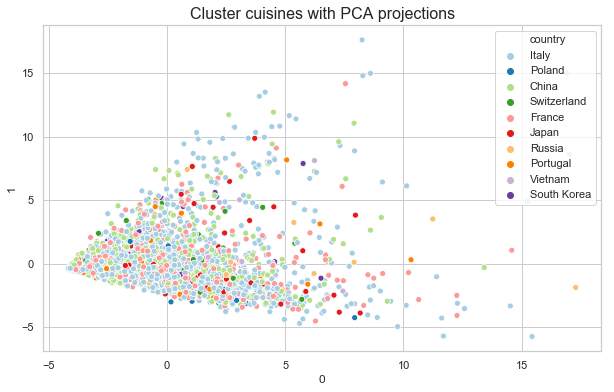

In [78]:
# Plotting the clusters on with PCA projections
plt.figure(figsize=(10,6))
sns.set(style="whitegrid")
sns.scatterplot(0, 1, data=pca_result, palette='Paired', hue='country')
plt.title('Cluster cuisines with PCA projections', fontsize=16)
plt.show()

In [86]:
# Apply TSNE , verbose=1, perplexity=30, n_iter=500, 
X_tsne = TSNE(n_components=3,verbose=1,metric=scipy.spatial.distance.cosine).fit_transform(pca_result_100)

df_r = pd.DataFrame(data = X_tsne, columns = ['tsne-1', 'tsne-2', 'tsne-3'])
df_r.loc[:,'country'] = df_selected_con.country.reset_index(drop=True)
df_r.head()

,tsne-1,tsne-2,tsne-3,country
0,-8.945289,17.982065,7.481405,China
1,-7.060218,-11.581836,-14.252477,China
2,22.845903,-16.155251,-0.112904,China
3,5.900351,7.845163,-11.952667,China
4,34.960960,-9.711546,11.295752,China


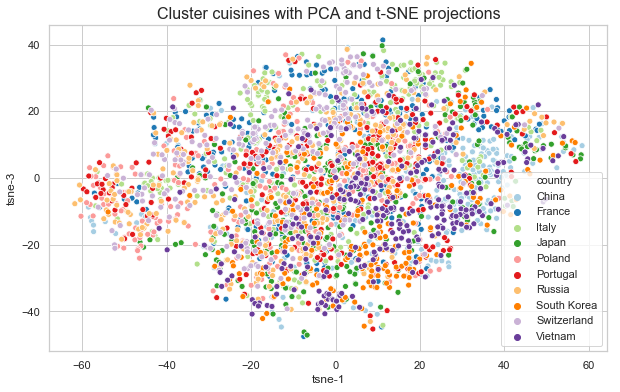

In [87]:
# Plotting the clusters on with t-sne projections
plt.figure(figsize=(10,6))
sns.set(style="whitegrid")
sns.scatterplot('tsne-1', 'tsne-3', data=df_r, palette='Paired', hue='country')
plt.title('Cluster cuisines with PCA and t-SNE projections', fontsize=16)
plt.show()

In [93]:
df = pd.DataFrame(np.zeros((300,1)))
for coun, group in df_r.groupby('country'):
    df[coun + str(0)] = group.iloc[:, 0].reset_index(drop=True)
    df[coun + str(1)] = group.iloc[:, 1].reset_index(drop=True)
    df[coun + str(2)] = group.iloc[:, 2].reset_index(drop=True)
df.to_csv('data/scatter3.csv')

## 2.2 Visualization with flow chart (code)

Here we relate the seasoning with health indices via nations. The connection between countries and seasoning indicating the frequency of certain seasonings used in recipes of the associate countries and the connection between countries and health indices indicates the amplitude of health indices at those countries.

In [95]:
df_health_coun = pd.read_pickle('data/health_country.pkl')
df_rel = pd.read_pickle('data/relationship.pkl')
df_rel.head()

,country,spice,honey,butter,oil,salt,pepper,cheese,sugar,clove,...,parsley,cayenne,nutmeg,paprika,sesame,bay,syrup,cardamom,curry,anise
1,Argentina,NaN,0.002635,0.032938,0.117260,0.129117,0.192358,0.027668,0.028986,0.067194,...,0.073781,0.010540,0.005270,0.023715,NaN,0.015810,0.002635,NaN,0.001318,NaN
2,Australia,0.005988,0.016306,0.073883,0.106587,0.089544,0.098204,0.061999,0.089544,0.058498,...,0.031967,0.003501,0.005435,0.009581,0.008936,0.004883,0.010778,0.001566,0.009397,0.001290
3,Austria,0.008197,NaN,0.125683,0.057377,0.151639,0.094262,0.032787,0.165301,0.035519,...,0.032787,0.005464,0.017760,0.025956,0.001366,0.012295,0.005464,0.001366,0.001366,0.001366
4,Belgium,0.006667,0.006667,0.128000,0.064000,0.152000,0.121333,0.036000,0.109333,0.048000,...,0.044000,0.004000,0.024000,0.005333,NaN,0.021333,0.002667,NaN,0.001333,NaN
5,Brazil,0.002710,0.002710,0.043360,0.106594,0.125565,0.151762,0.029810,0.087624,0.066847,...,0.028004,0.009937,0.005420,0.009033,NaN,0.015357,0.002710,NaN,0.001807,0.000903


In [99]:
seasonings_sel = df_rel.columns[1:][(df_rel.std()/df_rel.mean()) > 1.1].values
df_rel_sel = df_rel[seasonings_sel].fillna(0)
df_rel_sel.index = df_rel.country

In [98]:
sel_coun = ['Switzerland', 'France', 'Italy', 'Sweden', 'China', 'New Zealand', 'Japan', 'Turkey']
df_sel = df_rel_sel.loc[sel_coun, :]
df_sel.head()

,spice,ginger,cilantro,basil,paprika,sesame,bay,cardamom,curry,anise
country,,,,,,,,,,
Switzerland,0.004005,0.002670,0.000000,0.008678,0.009346,0.002003,0.007343,0.002003,0.000668,0.001335
France,0.002973,0.004316,0.001439,0.015059,0.006043,0.000480,0.018224,0.000959,0.000863,0.000384
Italy,0.001725,0.000969,0.001087,0.053395,0.002836,0.000591,0.007847,0.000095,0.000095,0.000875
Sweden,0.021320,0.020633,0.000000,0.000688,0.005502,0.000000,0.008253,0.018569,0.002751,0.003439
China,0.010967,0.070969,0.011420,0.001541,0.001450,0.082570,0.000544,0.000000,0.003535,0.003716


In [126]:
x = np.arange(0, 10, 1)
y = np.arange(10, 18, 1)
xx, yy = np.meshgrid(x, y)

source_1 = xx.reshape(1,-1)
source_1

target_1 = yy.reshape(1,-1)
target_1

value_1 = df_sel.values.reshape(1,-1)
value_1 *= 1000

color_links = ['rgba(253, 227, 212, 0.5)'] * 80
color_links

color_node_1 =[
            "aliceblue", "antiquewhite", "aqua", "aquamarine", "azure",
            "beige", "bisque", "black", "blanchedalmond", "blue",
    
            "blueviolet", "brown", "dimgrey", "dodgerblue", 
            "firebrick", "floralwhite", "forestgreen", "gold"]

In [104]:
df_sel_heal = df_health_coun[df_health_coun.country.isin(sel_coun)].drop(['income group', 'GNP per capita($)'], axis=1)
df_sel_heal.index = df_sel_heal.country
df_sel_heal.drop('country', axis=1, inplace=True)
df_stand_heal = (df_sel_heal - df_sel_heal.min()) / (df_sel_heal.max() - df_sel_heal.min())
df_stand_heal_sparse = df_stand_heal[df_stand_heal > 0.5].fillna(0)

In [105]:
disease = df_stand_heal.columns.values
dise = []
for i in disease:
    if(i.endswith('(%)')):
        dise.append(i[:-3])
    else:
        dise.append(i)
dise

['Life span',
 'Overweight',
 'High Blood Glucose',
 'High Blood Pressure',
 'High Cholesterol',
 'NCD death probability',
 'Malignant neoplasms death',
 'Diabetes mellitus death',
 'Cardiovascular diseases death',
 'Chronic obstructive pulmonary disease death']

In [125]:
x = np.arange(18, 28, 1)
y = np.arange(10, 18, 1)
xx, yy = np.meshgrid(x, y)

source_2 = yy.reshape(1,-1)

target_2 = xx.reshape(1,-1)

value_2 = df_stand_heal_sparse.values.reshape(1,-1)


color_node_2 =[
            "linen", "magenta", "maroon", "mediumaquamarine", "mediumblue",
            "mediumorchid", "mediumpurple", "mediumseagreen", "lime", "limegreen",]

In [ ]:
fig = go.Figure(data=[go.Sankey(
    node = dict(
      pad = 15,
      thickness = 20,
      #line = dict(color = "black", width = 0.5),
      label = list(seasonings_sel) + sel_coun + dise,
      color = color_node_1 + color_node_2
    ),
    link = dict(
      source = list(source_1[0]) + list(source_2[0]), # indices correspond to labels, eg A1, A2, A2, B1, ...
      target = list(target_1[0]) + list(target_2[0]),
      value = list(value_1[0]) + list(value_2[0]*20),
      #color = color_links_1 + color_links_2
  ))])

fig.update_layout(title_text="Basic Sankey Diagram", font_size=10)
fig.show()

In [127]:
df_output = pd.DataFrame(np.zeros((160,1)))
df_output['source'] = list(source_1[0]) + list(source_2[0])
df_output['target'] = list(target_1[0]) + list(target_2[0])
df_output['value'] = list(value_1[0]) + list(value_2[0]*200)
df_output['color_nodes'] = pd.Series(color_node_1 + color_node_2)
df_output['label'] = pd.Series(list(seasonings_sel) + sel_coun + dise)
df_output.to_csv('data/flow_chart_seasonings_country_diseases.csv')

Display correlation using flow chart.

In [112]:
df_nutr = pd.read_csv('data/nutrition_corr.csv')

In [129]:
x = np.arange(0, 10, 1)
y = np.arange(10, 16, 1)
xx, yy = np.meshgrid(x, y)

source_1 = xx.reshape(1,-1)
source_1

target_1 = yy.reshape(1,-1)
target_1

value_1 = df_nutr.drop('Unnamed: 0', axis=1).transpose().values.reshape(1,-1)
#value_1 *= 1000

color_node_1 =[
            "aliceblue", "antiquewhite", "aqua", "aquamarine", "azure",
            "beige", "bisque", "black", "blanchedalmond", "blue",
    
            "blueviolet", "brown", "dimgrey", "dodgerblue", 
            "firebrick", "floralwhite"]
label1 =  dise + ['total_fat', 'sugar', 'sodium',
       'protein', 'sat_fat', 'carbs']

In [ ]:
fig = go.Figure(data=[go.Sankey(
      node = dict(
      pad = 15,
      thickness = 20,
      #line = dict(color = "black", width = 0.5),
      label = label1,
      color = color_node_1
    ),
    link = dict(
      source = list(source_1[0]), # indices correspond to labels, eg A1, A2, A2, B1, ...
      target = list(target_1[0]),
      value = list(value_1[0]),
      #color = color_links_1 + color_links_2
  ))])

fig.update_layout(title_text="Basic Sankey Diagram", font_size=10)
fig.show()

In [130]:
df_output = pd.DataFrame(np.zeros((60,1)), columns=['source'])
df_output['source'] = list(source_1[0])
df_output['target'] = list(target_1[0])
df_output['value'] = list(value_1[0])
df_output['color_nodes'] = pd.Series(color_node_1)
df_output['label'] = pd.Series(label1)
df_output.to_csv('data/flow_chart_disease_nutrition.csv')

# 3. Incoporating WHO dataset

To study the potential relationship between eating habits and public health, we include some statistics related to public health from WHO in our dataset. They are available on WHO website.

The data imported comprise:
- life span
- the ratio of population dead from some health issues(overweight, high blood pressure, high blood glucose, etc.) 
- the total number of people dead from NCD(non-communicable diseases) believed to have close relationship to diet(dabetes mellitus and cardiovascular diseases) of various countries.

To render the NCD disease death data consistent on scale, we further add each nation's population to calculate the death rate of each NCD disease. The population data is retrived from world bank website and the name of locations are different from those in WHO dataset, thus we need to manually identify and unify country names.

Since the most recent available data on diseases are collected in 2016, for the sake of coherence, we use 2016 version of all the statistics. The first one to read in is the life span.

In [5]:
health_data= pd.read_csv('data/RAW_lifespan.csv')
health_data = health_data[health_data['Indicator']=='Life expectancy at birth (years)']
health_data = health_data[health_data['Dim1'] == 'Both sexes']
health_data.drop(columns=['Indicator','Period','Dim1'],inplace=True)
health_data.rename(columns={'First Tooltip':'Life span'},inplace=True)
health_data.reset_index(drop=True, inplace=True)

Then we add some food-related common health indices which include 'overweight', 'blood_pressure', 'blood_glucose', 'cholesterol'. The data shows the ratio of population in a country suffering from these common diseases and the death rate of various NCD(non-communicable diseases, including Malignant neoplasms, Diabetes mellitus, Cardiovascular diseases, Chronic obstructive pulmonary disease) in different countries.

In [6]:
data_disease= pd.read_csv('data/data_disease_death.csv')
data_disease = data_disease[['Location','Dim2','First Tooltip']]

In [7]:
dataset_list = ['data_overweight.csv', 'data_blood_glucose.csv', 'data_blood_pressure.csv', 
                'data_cholesterol.csv', 'data_NCD_death.csv']
column_names = ['Overweight(%)', 'High Blood Glucose(%)', 'High Blood Pressure(%)', 'High Cholesterol(%)',
                'NCD death probability(%)']

In [8]:
for ind, dataset in enumerate(dataset_list):
    data_sub = pd.read_csv(os.path.join('data', dataset))
    data_sub.rename(columns={'First Tooltip':column_names[ind]}, inplace=True)
    health_data = health_data.merge(data_sub[['Location',column_names[ind]]])

In [9]:
cols = ['Overweight(%)','High Blood Glucose(%)','High Blood Pressure(%)','High Cholesterol(%)']
for c in cols:
    health_data[c]=health_data[c].str.split('[',expand=True)[0].astype('float')

In [10]:
diseases = ['Malignant neoplasms','Diabetes mellitus','Cardiovascular diseases','Chronic obstructive pulmonary disease']
for d in diseases:
    data_sub=data_disease.loc[data_disease['Dim2']==d].copy()
    data_sub.rename(columns={'First Tooltip': d + ' death(%)'},inplace=True)
    health_data=pd.merge(health_data,data_sub[['Location',d+' death(%)']],on='Location')

Include population data into health data.

In [11]:
data_pop= pd.read_csv('data/data_population.csv')
data_pop = data_pop[data_pop['Time']==2016][['Location','PopTotal']]

Unification of country names.

In [12]:
value_WHO = ['Russia', 'United Kingdom', 'Iran', 'Viewnam', 'South Korea']
to_replace_WHO = ['Russian Federation', 'United Kingdom of Great Britain and Northern Ireland', 
                     'Iran (Islamic Republic of)', 'Viet Nam', "Democratic People's Republic of Korea"]
value_WB = ['Russia', 'Iran', 'Vietnam', 'South Korea']
to_replace_WB = ['Russian Federation', 'Iran (Islamic Republic of)', 'Viet Nam', "Dem. People's Republic of Korea"]

In [13]:
data_pop.replace(value=value_WB,to_replace=to_replace_WB,inplace=True)

In [14]:
health_data.replace(value=value_WHO, to_replace=to_replace_WHO, inplace=True)

In [15]:
health_data = health_data.merge(data_pop, on='Location')

We calculate death rate of diseases by using the population data.

In [16]:
diseases = ['Malignant neoplasms','Diabetes mellitus','Cardiovascular diseases','Chronic obstructive pulmonary disease']
for d in diseases:
    health_data[d + ' death(%)'] /= (health_data['PopTotal'] * 10)

The GNI per capita is the dollar value of a country's final income in a year, divided by its population. It should be reflecting the average before tax income of a country's citizens. In particular, a country's GNI per capita tends to be closely linked with other indicators of public health of a country. For example the life span in wealthy countries is usually higher than poorer ones. The data comes from world bank: https://data.worldbank.org/indicator/NY.GNP.PCAP.CD and according to the criterion given by world bank (see the table below), the countries are divided into different income groups (High-income, Upper-middle-income, Lower-middle-income, Low-income). Again we use data in 2016.

| Thresholds    |  GNI/Capita (current US$)|
| ------------- |:-------------:|
| Low-income    | < 1006 |
| Lower-middle income     | 1,006 - 3,955     |
| Upper-middle income | 3,956 - 12,235      |
|High-income    | > 12,235|

In [17]:
data_gni=pd.read_csv('data/GNI_per_capita.csv')
data_gni=data_gni[['Country Name','2016']]
data_gni.rename(columns={'Country Name':'Location','2016':'GNP per capita($)'},inplace=True)

In [18]:
data_gni.replace(value=value_WB, to_replace=to_replace_WB, inplace=True)

In [19]:
data_gni.replace(value='United States of America', to_replace='United States', inplace=True)

In [20]:
health_data = pd.merge(health_data,data_gni,on='Location')

In [21]:
health_data.dropna(inplace=True)
health_data.reset_index(drop=True, inplace=True)

In [22]:
health_data['income group'] = np.nan

In [23]:
health_data['income group'].iloc[health_data[health_data['GNP per capita($)'] < 1006].index] = 'low'
health_data['income group'].iloc[health_data[(health_data['GNP per capita($)'] >= 1006)
                                              & (health_data['GNP per capita($)'] < 3955)].index] = 'lower-middle'
health_data['income group'].iloc[health_data[(health_data['GNP per capita($)'] >= 3956)
                                              & (health_data['GNP per capita($)'] < 12235)].index] = 'upper-middle'
health_data['income group'].iloc[health_data[health_data['GNP per capita($)'] > 12235].index] = 'high'

In [24]:
health_data.rename(columns={'Location': 'country'},inplace=True)

In [25]:
health_data[health_data['income group'] == 'high'].country.unique()

array(['Antigua and Barbuda', 'Australia', 'Austria', 'Bahrain',
       'Barbados', 'Belgium', 'Brunei Darussalam', 'Canada', 'Chile',
       'Croatia', 'Cyprus', 'Denmark', 'Estonia', 'Finland', 'France',
       'Germany', 'Greece', 'Hungary', 'Iceland', 'Ireland', 'Israel',
       'Italy', 'Japan', 'Kuwait', 'Latvia', 'Lithuania', 'Luxembourg',
       'Malta', 'Netherlands', 'New Zealand', 'Norway', 'Oman', 'Panama',
       'Poland', 'Portugal', 'Qatar', 'Saudi Arabia', 'Seychelles',
       'Singapore', 'Slovenia', 'Spain', 'Sweden', 'Switzerland',
       'Trinidad and Tobago', 'United Arab Emirates', 'United Kingdom',
       'United States of America', 'Uruguay'], dtype=object)

In [26]:
health_data[health_data['income group'] == 'upper-middle'].country.unique()

array(['Albania', 'Algeria', 'Argentina', 'Azerbaijan', 'Belarus',
       'Belize', 'Bosnia and Herzegovina', 'Botswana', 'Brazil',
       'Bulgaria', 'China', 'Colombia', 'Costa Rica',
       'Dominican Republic', 'Ecuador', 'Equatorial Guinea', 'Fiji',
       'Gabon', 'Grenada', 'Guyana', 'Iraq', 'Jamaica', 'Kazakhstan',
       'Lebanon', 'Libya', 'Malaysia', 'Maldives', 'Mauritius', 'Mexico',
       'Montenegro', 'Namibia', 'Paraguay', 'Peru', 'Romania', 'Russia',
       'Samoa', 'Serbia', 'South Africa', 'Suriname', 'Thailand', 'Tonga',
       'Turkey', 'Turkmenistan'], dtype=object)

In [27]:
health_data[health_data['income group'] == 'lower-middle'].country.unique()

array(['Angola', 'Armenia', 'Bangladesh', 'Bhutan', 'Cabo Verde',
       'Cambodia', 'Cameroon', 'Comoros', 'Djibouti', 'El Salvador',
       'Eswatini', 'Georgia', 'Ghana', 'Guatemala', 'Honduras', 'India',
       'Indonesia', 'Jordan', 'Kenya', 'Kiribati', 'Lesotho',
       'Mauritania', 'Mongolia', 'Morocco', 'Myanmar', 'Nicaragua',
       'Nigeria', 'Pakistan', 'Papua New Guinea', 'Philippines',
       'Sao Tome and Principe', 'Senegal', 'Solomon Islands', 'Sri Lanka',
       'Tajikistan', 'Timor-Leste', 'Tunisia', 'Ukraine', 'Uzbekistan',
       'Vanuatu', 'Zambia', 'Zimbabwe'], dtype=object)

# 4. Relationship between eating habits and health

Recipes reflect the eating habits of a country. In the following, based on the data collected from recipes, we study the relation between nutrition in food and health indices as well as relation between ingredients + cooking methods with health indices to identify good eating and cooking practices that are beneficial to one's health.

## 4.1 Nutrition in food v.s. health indices

In essence, the significance of eating is to provide nutrition to our body so that it can go on functioning. Therefore, the nutrition in food should have a direct impact on health.

In [38]:
nutrition_health = pd.merge(health_data, avg_nutrition, on='country')

In [39]:
nutrition_health.groupby('income group').count()['country']

income group
high            24
low              1
lower-middle     5
upper-middle    11
Name: country, dtype: int64

In [40]:
corr = nutrition_health.corr()
corr.iloc[:10,11:]

,GNP per capita($),id,minutes,contributor_id,n_steps,n_ingredients,calories(kJ),total_fat(g),sugar(g),sodium(mg),protein(g),sat_fat(g),carbs(g)
Life span,0.759489,-0.116559,0.261140,-0.293373,-0.025591,-0.633051,0.241732,0.011583,0.259661,-0.057489,-0.084768,0.048221,0.327654
Overweight(%),0.372351,0.113195,0.179199,-0.551937,0.033698,-0.553425,0.101498,-0.063770,0.206901,-0.474451,-0.278947,-0.077577,0.258986
High Blood Glucose(%),-0.635784,0.400637,-0.265491,-0.050469,-0.088001,0.409108,-0.595456,-0.485538,-0.429823,-0.285778,-0.051460,-0.603180,-0.444161
High Blood Pressure(%),-0.693256,0.219245,-0.157368,0.326224,0.354805,0.596934,-0.004557,0.163421,-0.361444,0.197350,0.260549,0.041858,-0.189817
High Cholesterol(%),0.721382,-0.214190,0.437015,-0.370411,0.163721,-0.639253,0.448666,0.139987,0.427718,0.011962,0.007618,0.234125,0.520052
NCD death probability(%),-0.736702,-0.058652,-0.204770,0.104940,0.189506,0.538824,-0.267261,-0.106641,-0.218706,0.048558,0.133106,-0.164687,-0.306701
Malignant neoplasms death(%),0.599007,-0.325419,0.302996,-0.130427,0.312752,-0.523657,0.445057,0.231457,0.304935,0.244170,0.021630,0.237461,0.432580
Diabetes mellitus death(%),-0.269987,0.012261,-0.170994,-0.001626,-0.002721,0.229192,-0.042244,-0.083272,-0.003125,0.053068,0.244765,-0.126674,-0.032228
Cardiovascular diseases death(%),0.055472,-0.299596,0.044370,-0.072371,0.595595,-0.085945,0.171680,0.073564,-0.003937,0.214339,0.093035,0.037188,0.154417
Chronic obstructive pulmonary disease death(%),0.376520,-0.282496,0.217241,-0.019546,0.089784,-0.215126,0.254529,0.179312,0.149614,0.205215,0.187592,0.028258,0.129941


In [42]:
nutri_heal_upper = nutrition_health[nutrition_health['income group']=='upper-middle'].drop(columns = ['GNP per capita($)','income group','PopTotal'])
corr = nutri_heal_upper.corr()
corr.iloc[:10,11:]

,minutes,contributor_id,n_steps,n_ingredients,calories(kJ),total_fat(g),sugar(g),sodium(mg),protein(g),sat_fat(g),carbs(g)
Life span,-0.259877,0.271704,-0.249955,0.070009,-0.217903,0.091240,-0.635260,0.009832,0.357643,-0.308662,-0.845172
Overweight(%),0.718892,-0.435681,-0.029682,-0.787782,-0.219897,-0.062811,-0.164641,-0.742349,-0.617553,-0.250733,0.041583
High Blood Glucose(%),0.497441,-0.424117,-0.120150,-0.305859,-0.457277,-0.357167,-0.220324,-0.492584,-0.421994,-0.487391,0.004963
High Blood Pressure(%),0.188882,-0.323434,0.328335,-0.120665,0.301516,0.036272,0.534939,-0.173321,-0.336384,0.451303,0.753056
High Cholesterol(%),-0.182173,0.314367,-0.196835,0.289648,0.167077,0.180313,-0.265545,0.049660,0.315751,0.491240,-0.089051
NCD death probability(%),0.459951,-0.258383,0.586902,-0.196226,0.065402,-0.183871,0.470932,-0.119147,-0.493787,0.130316,0.721054
Malignant neoplasms death(%),-0.185895,0.225327,0.628179,0.061171,0.144756,0.136555,0.087514,0.233143,-0.012547,0.049247,-0.016803
Diabetes mellitus death(%),0.168631,0.300104,-0.398273,-0.050523,0.214891,0.066109,0.249189,0.196472,0.053045,0.418786,0.372823
Cardiovascular diseases death(%),0.222840,0.149840,0.763410,-0.088303,-0.112721,-0.155847,0.026571,0.046442,-0.248884,-0.085614,0.087493
Chronic obstructive pulmonary disease death(%),-0.554606,0.103750,0.100871,0.261943,0.650894,0.771255,-0.063263,0.420502,0.504648,0.218511,-0.290329


In [43]:
nutri_heal_high = nutrition_health[nutrition_health['income group']=='high'].drop(columns = ['GNP per capita($)','income group','PopTotal'])
corr = nutri_heal_high.corr()
corr.iloc[:10,11:]

,minutes,contributor_id,n_steps,n_ingredients,calories(kJ),total_fat(g),sugar(g),sodium(mg),protein(g),sat_fat(g),carbs(g)
Life span,-0.010694,0.183120,-0.219301,-0.371737,-0.049026,-0.057705,0.062555,0.045895,-0.164731,0.043956,-0.062883
Overweight(%),0.073882,-0.572031,-0.075462,0.155269,0.095851,0.184828,0.134007,-0.684462,-0.004829,0.190004,0.044334
High Blood Glucose(%),-0.152756,-0.142032,-0.148717,0.334446,-0.450630,-0.498669,-0.319632,-0.154313,-0.066136,-0.546972,-0.278531
High Blood Pressure(%),0.025081,-0.015728,0.556046,0.498848,0.190820,0.223891,-0.288262,0.322734,0.441636,-0.009861,0.028653
High Cholesterol(%),0.504274,0.113833,0.305718,-0.327317,0.646837,0.644483,0.379575,0.241169,0.204225,0.645026,0.438653
NCD death probability(%),0.024786,-0.060901,0.390981,0.442816,0.131468,0.229875,-0.086784,0.183226,0.334145,0.021633,0.025364
Malignant neoplasms death(%),0.146849,0.459902,0.380144,0.111644,0.301486,0.419713,-0.028289,0.598962,0.385527,0.235240,0.058473
Diabetes mellitus death(%),-0.196536,-0.039474,0.309968,0.525602,0.175464,0.174748,-0.020268,0.099326,0.494912,-0.112143,0.045104
Cardiovascular diseases death(%),-0.068473,0.181959,0.592747,0.447236,0.259514,0.408090,-0.220334,0.464013,0.445405,0.174779,0.015862
Chronic obstructive pulmonary disease death(%),0.123350,0.474292,0.024139,0.175389,0.034508,0.159382,-0.080101,0.387436,0.293257,-0.092167,-0.162844


We look at the the result but haven't find the similar relationship between them.

## 4.2 Relationship between seasoning and health indices

We aimed to see if above health indices, like life span have relationship with seasoning intake or not. This part contains four steps:
1. We are going to get the data which contains the percentage of each seasoning in each country by counting their occurence. 
2. Build our naive model that these health indices are only influenced by the income and seasoning intake. Then we do the sensitivity analysis to test our model. 

3. Get the mask for showing the relationship between each seasoning and health which is 1 if the model is true and 0 if the model is false.
4. Apply the mask to corrrelation matrix between seasoning and health.

In [161]:
data_wealth = pd.merge(data_revised_seasoning,health_data, on='country')

Since there is no seasoning appearing in at least 5 countries' recipes, we decide to generalize the seasoning list by dropping some charateristic adjectives. For any seasoning, as long as it contains words in seasoning list defined below, it will be counted as the corresponding seasoning.

In [162]:
seasonings = ['salt', 'sugar', 'butter', 'spice','pepper','chili', 'onion','garlic',  'oil',
         'ginger','vinegar','clove', 'herb','mayonnaise','vanilla','honey', 'cinnamon', 'curry',
        'mustard', 'olive', 'basil', 'oregano', 'sesame', 'thyme','paprika', 'cajun', 'cardamom',
        'rosemary','nutmeg', 'parsley', 'coriander', 'bay', 'cumin', 'tarragon','allspice',
        'cayenne', 'anise', 'celery', 'dill', 'wasabi', 'mace', 'syrup', 'cilantro',
        'salt', 'spice', 'pepper', 'chili', 'onion', 'clove', 'herb', 'olive', 'nutmeg', 'sauce', 'juice',
         'powder', 'harissa', 'sake', 'ketchup', 'mirin', 'miso']

In [163]:
def generalize_seasoning(string):
    for seasoning in seasonings:
        if seasoning in string:
            return seasoning
    return None

In [164]:
data_wealth.seasoning = data_wealth.seasoning.apply(generalize_seasoning)

In [165]:
data_wealth.dropna(subset=['seasoning'], inplace=True)

We group data into three classes to do the research between seasoning and health because we believe that the health data, such as life span will be largely influenced by income. 

In [ ]:
data_wealth[data_wealth['income group']=='upper-middle'].groupby('seasoning')['country'].nunique()>10
data_wealth[data_wealth['income group']=='lower-middle'].groupby('seasoning')['country'].nunique()>10
data_wealth[data_wealth['income group']=='low'].groupby('seasoning')['country'].nunique()>10
data_wealth[data_wealth['income group']=='high'].groupby('seasoning')['country'].nunique()>10

Since there is no seasoning appearing in at least 5 countries' recipes in low, lower-middle and upper-middle classes. We decide to take look at high income group. Also there is potential benefit that high-income countries have similar living condition and less other factors to influence our health indices

We ignore the seasoning which can be only found in less than 10 coutries in order to reduce bias

In [204]:
ignored_seasoning=['wasabi','cajun','mirin','sake','miso','harissa',]
data_wealth = data_wealth[~data_wealth['seasoning'].isin(ignored_seasoning)]

In [205]:
data_wealth = data_wealth[data_wealth['income group']=='high']

Get occurence of all seasoning in every countries.

In [206]:
countall = data_wealth.groupby('country')['seasoning'].count().reset_index(name='countall')
count_seasoning=data_wealth.groupby(['country','seasoning'])['seasoning'].count().reset_index(name='count')
count = pd.merge(count_seasoning, countall, on='country')
count['count_percent'] = count['count']/count['countall']

Get the percentage of each seasoning occurence in different countries.

In [ ]:
seasonings = data_wealth['seasoning'].unique().tolist()
data=countall.country
for s in seasonings:
    data_sub=count.loc[count['seasoning']==s]
    data_sub.rename(columns={'count_percent':s},inplace=True)
    data=pd.merge(data,data_sub[['country',s]],on='country',how='left')
data.fillna(value=0,inplace=True)
data

Now we have data and we can do the sensitivity analysis to see if our naive hypothesis is resonable or not

In [ ]:
health_list=['Malignant neoplasms death(%)', 'NCD death probability(%)',
        'Cardiovascular diseases death(%)','Diabetes mellitus death(%)',
       'Chronic obstructive pulmonary disease death(%)','Life span','Overweight(%)','High Blood Glucose(%)',
       'High Blood Pressure(%)','High Cholesterol(%)']

In [240]:
seasoning_list = data_wealth.seasoning.unique().tolist()

In [237]:
def get_country(data_seasoning, seasoning, index, threshold):
    data_high = data_seasoning[data_seasoning[seasoning] > threshold[1]]['country'].tolist()
    data_low = data_seasoning[data_seasoning[seasoning] <= threshold[0]]['country'].tolist()
    data_middle = data_seasoning[data_seasoning[seasoning] < threshold[1]]
    data_middle = data_middle[data_middle[seasoning] > threshold[0]]['country'].tolist()
    return data_high, data_middle, data_low

Define the function to calculate sensitivity. 

$$\frac1{\Gamma}\leq\frac{\pi_k/(1-\pi_k)}{\pi_l/(1-\pi_l)}\leq\Gamma$$

Here again we group the countries into three classes: the one with high percentage intake of one seasoning(0 - 33% percentile), the one has middle percentage intake(33% - 66% percentile) and the rest has lower intake. Now we control the two variables: income and the intake of seasoning. We want to make a mask in the form of dataframe to indicate whether our hypothesis (only these two factors have influence on health indices) is true or not. In a clearer form, we state the hypothesis as there are no other factors that influence the health indices — countries with similar income levels and seasoning intake levels are similar in this regard.

We chooce $gammma$ equal to 2 to check our naive model between every seasoning and every health index. The health list above contains the health indices for which naive model is true. Then, still controling the income levels of countries, we try to analyze the influence of seasoning intake levels' influence, which is the only variable left.

In [238]:
def cal_sen(px,py):
    return (px/(1-px))/(py/(1-py))
def sensitivity_analysis(country_analyse, index, health_data):
    sen=[]
    for country1 in country_analyse:
        for country2 in country_analyse:
            if country1!=country2:           
                px = health_data[health_data['country']==country1][index].values[0]
                py =  health_data[health_data['country']==country2][index].values[0]
                sen.append(cal_sen(px,py))
    if np.max(sen)>2 or np.min(sen)<0.5:
        return 0
    else:
        return 1

In [298]:
df_mask = pd.DataFrame(index = seasoning_list, columns=health_list)
df_mask.iloc[:,:]=1
for health in health_list:
    for seasoning in seasoning_list:
        country_list = get_country(data, seasoning, health, [np.percentile(data[seasoning],33),np.percentile(data[seasoning],66)])
        for country in country_list:
            sensitivity = sensitivity_analysis(country, health, data_wealth)
            if sensitivity ==0:
                df_mask.loc[seasoning, health]=0 

In [300]:
df_mask

,Malignant neoplasms death(%),NCD death probability(%),Cardiovascular diseases death(%),Diabetes mellitus death(%),Chronic obstructive pulmonary disease death(%),Life span,Overweight(%),High Blood Glucose(%),High Blood Pressure(%),High Cholesterol(%)
oil,0,1,0,0,0,1,1,1,1,1
salt,0,1,0,0,0,1,1,1,1,1
spice,0,1,0,0,0,1,1,1,1,1
honey,0,1,0,0,0,1,1,1,1,1
butter,0,1,0,0,0,1,1,1,1,1
pepper,0,1,0,0,0,1,1,1,1,1
juice,0,1,0,0,0,1,1,1,1,1
sugar,0,1,0,0,0,1,1,1,1,1
mustard,0,1,0,0,0,1,1,1,1,1
vinegar,0,1,0,0,0,1,1,1,1,1


**Here we see in 'NCD death probability(%)', 'Life span', 'High Blood Glucose(%)', 'High Blood Pressure(%)', 'High Cholesterol(%)', 'Overweight(%)', our naive model is established. Consequently, we state that these health indices are largely, if not completely, influenced by income level and seasoning intake.**

In [247]:
indices = ['country', 'NCD death probability(%)', 'Life span', 'High Blood Glucose(%)', 'High Blood Pressure(%)', 'High Cholesterol(%)', 'Overweight(%)']

In [289]:
data_indices = data_wealth[indices]

In [290]:
data_all = pd.merge(data,data_indices, on='country')

In [ ]:
data_all = pd.merge(data,data_indices, on='country')
corres = data_all.corr()
corres = corres.iloc[:44,44:]

In [241]:
from utils import heatmap, annotate_heatmap

Let's take look at the some correlation between seasoning and health indices.

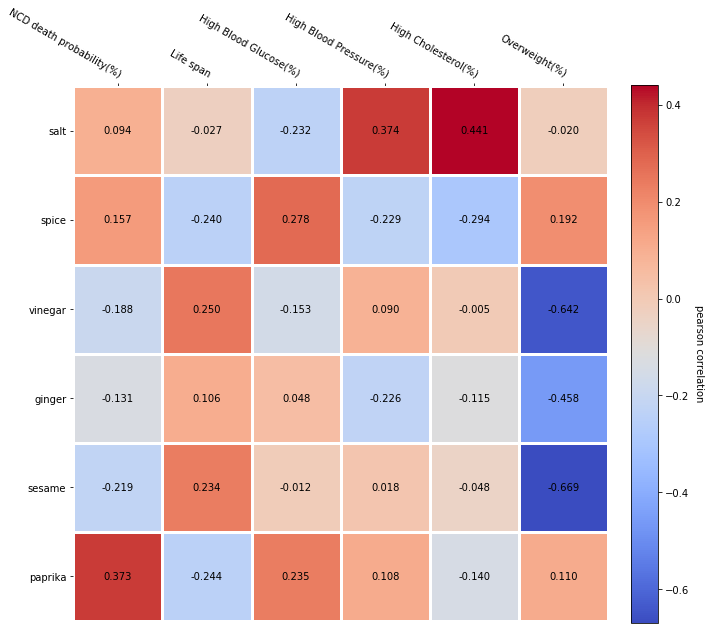

In [297]:
seasoning = ['salt','spice', 'vinegar' ,'ginger','sesame','paprika']
corres = corres.loc[seasoning]
corres
fig, ax = plt.subplots(figsize=(10,10))
       
im, cbar = heatmap(corres.values, corres.index, corres.columns, ax=ax,
                   cmap="coolwarm", cbarlabel="pearson correlation")
texts = annotate_heatmap(im, valfmt="{x:.3f}", threshold=0.7)
fig.tight_layout()
plt.show()

From the heatmap above, we can observe that high intake of salt may increase the risk of high cholesterol and high blood pressure and the consumption of ginger may reduce the risk of high blood pressure. As for life span, spicy seasoning is observed to be negatively related to life span, which could be interpreted that spicy seasonings reduce life span.